In [30]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from skimage.transform import resize
import tensorflow as tf

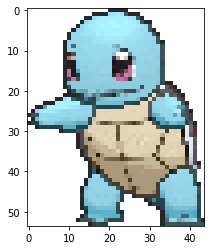

In [10]:
ch = imageio.imread('charmander-tight.png')
bb = imageio.imread('bulbasaur-tight.png')
sq = imageio.imread('squirtle-tight.png')
plt.imshow(sq)
plt.show()

In [11]:
POKE_DIM = 200
ch = np.array(ch)
bb = np.array(bb)
sq = np.array(sq)
CH_H, CH_W, CH_C = ch.shape
BB_H, BB_W, BB_C = bb.shape
SQ_H, SQ_W, SQ_C = sq.shape

# useful store these in an array
poke_data = [
  [ch, CH_H, CH_W, CH_C],
  [bb, BB_H, BB_W, BB_C],
  [sq, SQ_H, SQ_W, SQ_C],
]
class_names = ['Charmander', 'Bulbasaur', 'Squirtle']

In [12]:
def custom_loss(y_true, y_pred):
  # target is a 8-tuple
  # (row, col, depth, width, class1, class2, class3, object_appeared)

  bce = binary_crossentropy(y_true[:, :4], y_pred[:, :4]) # location
  cce = categorical_crossentropy(y_true[:, 4:7], y_pred[:, 4:7]) # object class
  bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1]) # object appeared

  return bce * y_true[:, -1] + cce * y_true[:, -1] + 0.5 * bce2

In [31]:
def make_model():
  vgg = tf.keras.applications.VGG16(
    input_shape=[POKE_DIM, POKE_DIM, 3],
    include_top=False,
    weights='imagenet')
  x = Flatten()(vgg.output)
  x1 = Dense(4, activation='sigmoid')(x) # location
  x2 = Dense(3, activation='softmax')(x) # object class
  x3 = Dense(1, activation='sigmoid')(x) # object appeared
  x = Concatenate()([x1, x2, x3])
  model = Model(vgg.input, x)
#   model.compile(loss=custom_loss, optimizer=SGD(learning_rate=0.01, momentum=0.9))
  model.compile(loss=custom_loss, optimizer=Adam(lr=0.0001))
  return model

In [24]:
from glob import glob
backgrounds = []

background_files = glob('backgrounds/*.jpg')
for f in background_files:
  # Note: they may not all be the same size
  bg = np.array(image.load_img(f))
  backgrounds.append(bg)

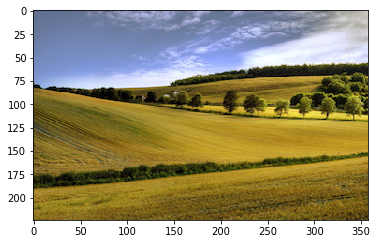

In [25]:
plt.imshow(backgrounds[3])

In [26]:
def pokemon_generator_multiclass(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 8))
      
      for i in range(batch_size):
        # select a random background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - POKE_DIM)
        rnd_w = np.random.randint(bg_w - POKE_DIM)
        X[i] = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()
        
        # 25% no object, 25% + 25% + 25% for the 3 classes
        appear = (np.random.random() < 0.75)
        if appear:
          
          # choose a pokemon
          pk_idx = np.random.randint(3)
          pk, h, w, _ = poke_data[pk_idx]

          # resize object - make it bigger or smaller
          scale = 0.5 + np.random.random()
          new_height = int(h * scale)
          new_width = int(w * scale)
          obj = resize(
              pk,
              (new_height, new_width),
              preserve_range=True).astype(np.uint8) # keep it from 0..255

          # maybe flip
          if np.random.random() < 0.5:
            obj = np.fliplr(obj)

          # choose a random location to store the object
          row0 = np.random.randint(POKE_DIM - new_height)
          col0 = np.random.randint(POKE_DIM - new_width)
          row1 = row0 + new_height
          col1 = col0 + new_width

          # can't 'just' assign obj to a slice of X
          # since the transparent parts will be black (0)
          mask = (obj[:,:,3] == 0) # find where the pokemon is 0
          bg_slice = X[i,row0:row1,col0:col1,:] # where we want to place `obj`
          bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
          bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
          X[i,row0:row1,col0:col1,:] = bg_slice # put the slice back
        
          # make targets

          # location
          Y[i,0] = row0/POKE_DIM
          Y[i,1] = col0/POKE_DIM
          Y[i,2] = (row1 - row0)/POKE_DIM
          Y[i,3] = (col1 - col0)/POKE_DIM

          # class
          Y[i,4 + pk_idx] = 1
        
        # did the pokemon appear?
        Y[i,7] = appear
      
      yield X / 255., Y

In [27]:
xx = None
yy = None
for x, y in pokemon_generator_multiclass():
  xx, yy = x, y
  break

[0.64  0.31  0.195 0.16  0.    0.    1.    1.   ]
percent no obj: 0.265625
percent charmander: 0.25
percent bulbasaur: 0.265625
percent squirtle: 0.21875


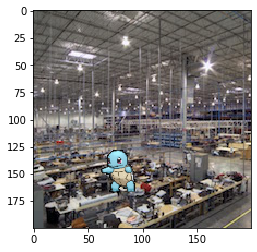

In [28]:
n = yy.shape[0]
idx = np.random.randint(n)
plt.imshow(xx[idx]);
print(yy[idx])
print("percent no obj:", (yy[:,7] == 0).sum() / n)
print("percent charmander:", yy[:,4].sum() / n)
print("percent bulbasaur:", yy[:,5].sum() / n)
print("percent squirtle:", yy[:,6].sum() / n)

In [32]:
model = make_model()
model.fit_generator(
    pokemon_generator_multiclass(),
    steps_per_epoch=50,
    epochs=5,
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
50/50 [==============================] - 1391s 28s/step - loss: 0.8348
Epoch 2/5
50/50 [==============================] - 1229s 25s/step - loss: 0.4153
Epoch 3/5
50/50 [==============================] - 1182s 24s/step - loss: 0.4157
Epoch 4/5
50/50 [==============================] - 1248s 25s/step - loss: 0.4035
Epoch 5/5
50/50 [==============================] - 1149s 23s/step - loss: 0.4026


In [33]:
# Make predictions
def pokemon_prediction_multiclass():
  # select a random background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - POKE_DIM)
  rnd_w = np.random.randint(bg_w - POKE_DIM)
  x = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()
  
  appear = (np.random.random() < 0.75)
  if appear:

    # choose a pokemon
    pk_idx = np.random.randint(3)
    pk, h, w, _ = poke_data[pk_idx]
        
    # resize charmander - make it bigger or smaller
    scale = 0.5 + np.random.random()
    new_height = int(h * scale)
    new_width = int(w * scale)
    obj = resize(
        pk,
        (new_height, new_width),
        preserve_range=True).astype(np.uint8) # keep it from 0..255

    # maybe flip
    if np.random.random() < 0.5:
      obj = np.fliplr(obj)

    # choose a random location to store the object
    row0 = np.random.randint(POKE_DIM - new_height)
    col0 = np.random.randint(POKE_DIM - new_width)
    row1 = row0 + new_height
    col1 = col0 + new_width

    # can't 'just' assign obj to a slice of X
    # since the transparent parts will be black (0)
    mask = (obj[:,:,3] == 0) # find where the pokemon is 0
    bg_slice = x[row0:row1,col0:col1,:] # where we want to place `obj`
    bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
    bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
    x[row0:row1,col0:col1,:] = bg_slice # put the slice back
    actual_class = class_names[pk_idx]
    print("true:", row0, col0, row1, col1, actual_class)
  
  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]
  
  # Plot
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  
  # Draw the box
  if p[-1] > 0.5:
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0 + p[2]*POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    class_pred_idx = np.argmax(p[4:7])
    class_pred = class_names[class_pred_idx]
    print("pred:", row0, col0, row1, col1, class_pred)
    rect = Rectangle(
        (p[1]*POKE_DIM, p[0]*POKE_DIM),
        p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  else:
    print("pred: no object")
  plt.show()

In [ ]:
pokemon_prediction_multiclass()